### COMP 473 Group Project

#### Facial Expression Recognition: 6-Class Classification

##### Import Libraries


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pathlib

#### Training Metrics Graph
Automatically update loss and accuracy of training and validation set and display the graph as the model gets trained

In [2]:
from IPython.display import clear_output


class PlotTrain(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        #To plot the graph
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], label='val_' + metric)

        axs[i].legend()
        axs[i].grid()
        plt.tight_layout()
        plt.show()

##### Dataset Import

In [3]:
def datasetImport(path):
    data_dir = pathlib.Path('D:\Concordia\COMP473\COMP_473_Project\CK+')
    image_count = len(list(data_dir.glob('*/*.png')))
    print("total image:", image_count)

    list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'), shuffle=False)
    list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

    #Split between training and test set
    test_size = int(image_count * 0.3)
    train = list_ds.skip(test_size)
    test_ds = list_ds.take(test_size)

    #Split within training: training set and validation set
    val_size = int(len(train) * 0.2)
    train_ds = train.skip(val_size)
    val_ds = train.take(val_size)

    return train_ds, val_ds, test_ds


### Load the data

In [4]:
path_CK_Augmented = '..\COMP_473_Project\CK_Augmented'
# path_CK_Augmented_ImageCrop = '..\COMP_473_Project\CK_Augmented_ImageCrop'
# path_CK_Augmented_IntensityNormalization = '..\COMP_473_Project\CK_Augmented_IntensityNormalization'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)


# data_CK_Augmented_ImageCrop = tf.keras.preprocessing.image_dataset_from_directory(
#     path_CK_Augmented_ImageCrop,
#     # our original dataset is 48 pixels by 48 pixels
#     image_size = (48,48),
#     batch_size = 20,
#     color_mode='grayscale'
# )



Found 1545 files belonging to 6 classes.


In [5]:
data_iterator = data_CK_Augmented.as_numpy_iterator()

In [6]:
batch = data_iterator.next()

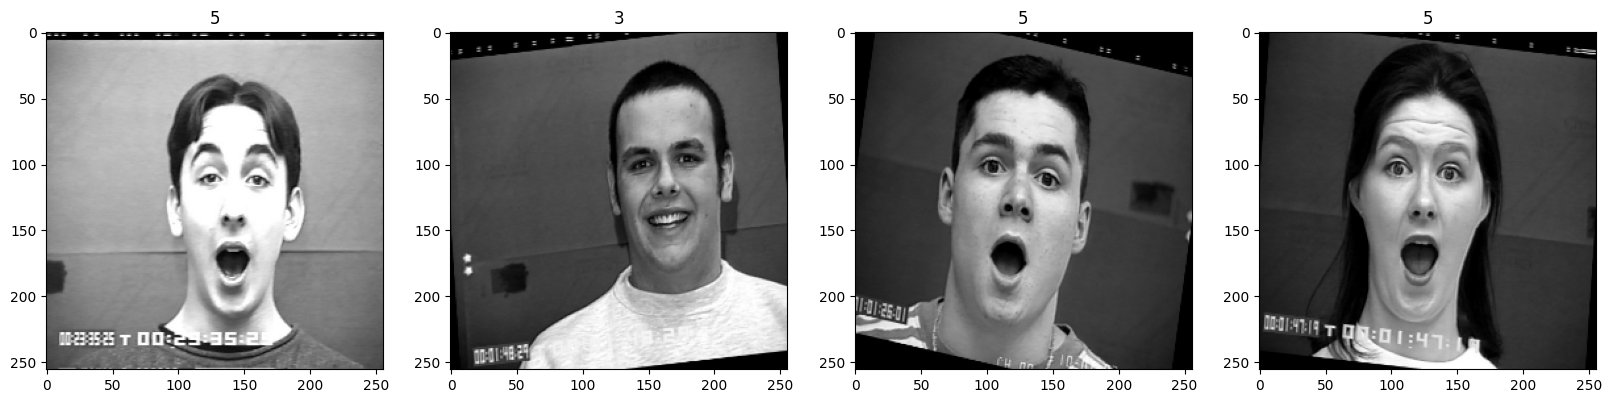

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Scale the data down


In [8]:
# data_CK_Augmented = data_CK_Augmented.map(lambda x, y: (x / 255, y))

In [9]:
data_CK_Augmented.as_numpy_iterator().next()

(array([[[[4.6165039e+01, 4.6165039e+01, 4.6165039e+01],
          [1.7018652e+02, 1.7018652e+02, 1.7018652e+02],
          [2.4939258e+02, 2.4939258e+02, 2.4939258e+02],
          ...,
          [2.6357422e+00, 2.6357422e+00, 2.6357422e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
 
         [[2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
          [5.5664062e-01, 5.5664062e-01, 5.5664062e-01],
          [9.4335938e-01, 9.4335938e-01, 9.4335938e-01],
          ...,
          [4.7167969e-01, 4.7167969e-01, 4.7167969e-01],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
 
         [[4.5710938e+01, 4.5710938e+01, 4.5710938e+01],
          [1.7589648e+02, 1.7589648e+02, 1.7589648e+02],
          [2.5182520e+02, 2.5182520e+02, 2.5182520e+02],
          ...,
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+

### Splitting the data

In [10]:
# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train_size: 43
val_size: 10
test_size: 23


In [11]:
train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test = data_CK_Augmented.skip(train_size + val_size).take(test_size)

In [12]:
print(train)
print(val)
print(test)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [84]:
tf.keras.Sequential??

##### Basic Model
No Pre-Processing Applied

<br>Model1_t1: Trained with Dataset 1

In [13]:
model1_t1 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems. 
    # If you add up the probability of each class we get 1. 
    tf.keras.layers.Dense(6, activation="softmax")
])
model1_t1.build()
# prints summary of our model.
model1_t1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      128       
                                                                 
 resizing (Resizing)         (None, 64, 64, 32)        0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                    

Compile and Fit(train) the basic models

<br> Model1_t1

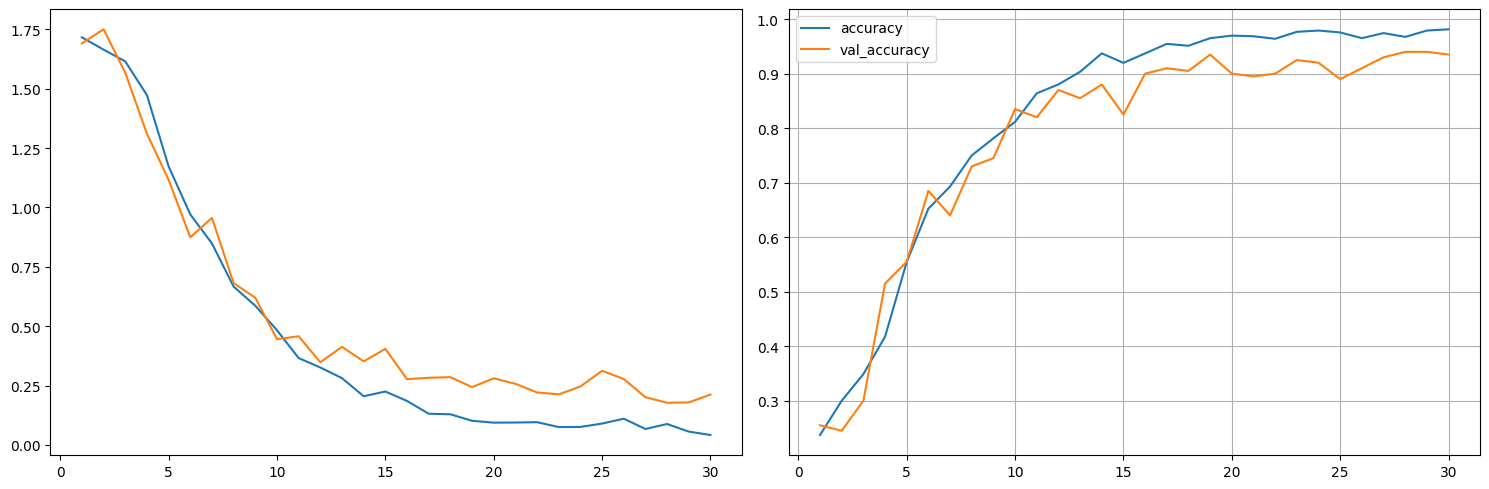

43/43 [==============================] - 7s 170ms/step - loss: 0.0416 - accuracy: 0.9814 - val_loss: 0.2117 - val_accuracy: 0.9350


In [15]:
# compile and fit the model1_t1
callback_list = [PlotTrain()]

model1_t1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model1_t1.fit(train, validation_data=val, epochs=30, callbacks=callback_list)

model1_t1.save("model1_t1.h5")

### Augmented Image cropping model for parameters

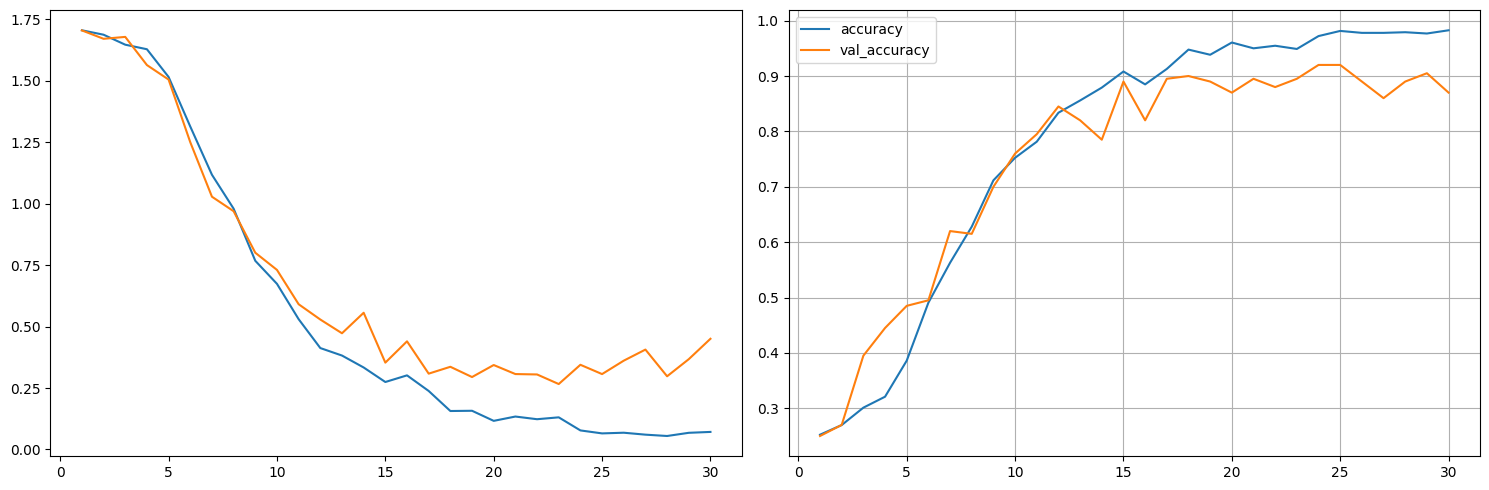

43/43 [==============================] - 7s 165ms/step - loss: 0.0714 - accuracy: 0.9826 - val_loss: 0.4502 - val_accuracy: 0.8700


In [17]:
path_CK_Augmented_ImageCrop = '..\COMP_473_Project\CK_Augmented_ImageCrop'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model2_t1 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model2_t1.build()
# prints summary of our model.
model2_t1.summary()

# compile and fit the model2_t1
callback_list = [PlotTrain()]

model2_t1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model2_t1.fit(train, validation_data=val, epochs=30, callbacks=callback_list)

model2_t1.save("model2_t1.h5")


### Augmented Intensity Normalization model for parameters


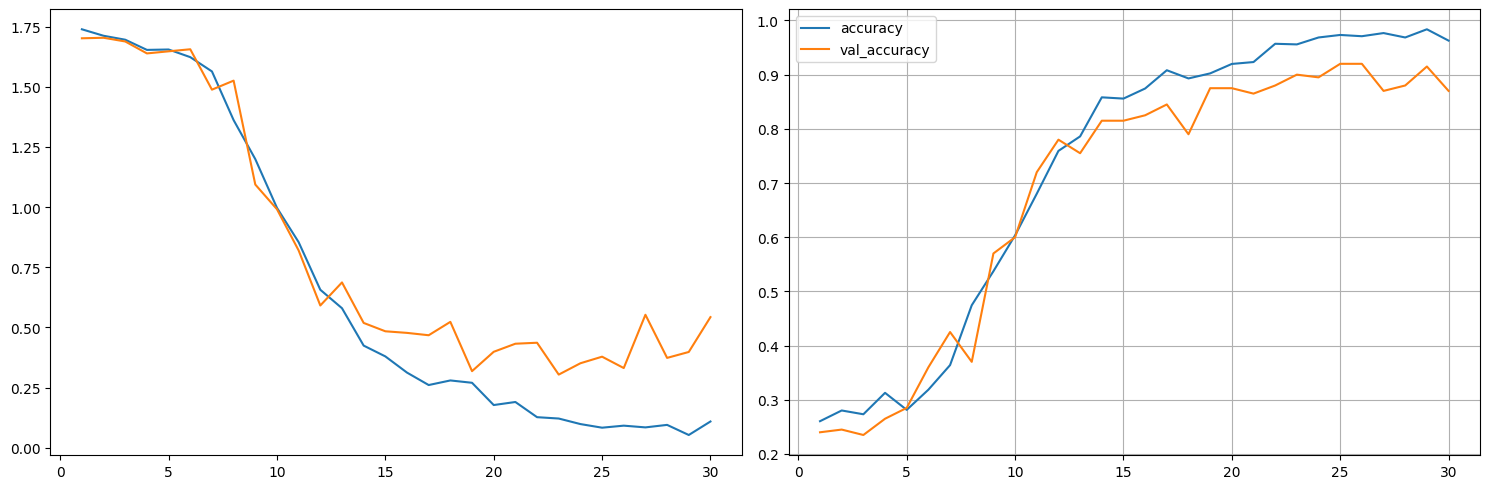

43/43 [==============================] - 7s 164ms/step - loss: 0.1090 - accuracy: 0.9628 - val_loss: 0.5427 - val_accuracy: 0.8700


In [18]:
path_CK_Augmented_IntensityNormalization = '..\COMP_473_Project\CK_Augmented_IntensityNormalization'

data_CK_Augmented = tf.keras.utils.image_dataset_from_directory(
    path_CK_Augmented,
    image_size=(256, 256),
    batch_size=20,
    # color_mode='grayscale'
)

# train_size = int(len(data)*.7)
# Split the train and test data 70 and 30 % respectively
train_size = int(len(data_CK_Augmented) * .56)
test_size = int(len(data_CK_Augmented) * .3)

# We then split the training data 80% for training and 20% for validation
val_size = int(len(data_CK_Augmented) * .14)
print('train_size: {}'.format(train_size))
print('val_size: {}'.format(val_size))
print('test_size: {}'.format(test_size))

train = data_CK_Augmented.take(train_size)
val = data_CK_Augmented.skip(train_size).take(val_size)
test = data_CK_Augmented.skip(train_size + val_size).take(test_size)

model3_t1 = tf.keras.Sequential([
    #resize layer to change image into 64x64
    tf.keras.layers.Conv2D(32, (1, 1), padding='valid', activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.Rescaling(1. / 255),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    # change image shape = (32, 32, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #input_shape = shape of the images made by Ryan
    #kernel size change to 5x5
    # tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu', input_shape=(28, 28, 3)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model3_t1.build()
# prints summary of our model.
model3_t1.summary()

# compile and fit the model3_t1
callback_list = [PlotTrain()]

model3_t1.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model3_t1.fit(train, validation_data=val, epochs=30, callbacks=callback_list)

model3_t1.save("model2_t1.h5")

Classification Test and Results
<li> Classification Report
<li> Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [ ]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 3)),

    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(64, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 7 final nodes because we have 7 classes.
    # softmax: compress resulting number between 0~1, used in category problems. 
    # If you add up the probability of each class we get 1. 
    tf.keras.layers.Dense(7, activation="softmax")
])

Use model.load() to test with each model

<br>Model1_t1: Basic model with dataset #1

In [ ]:
# test_dir = 'pathToTestData'

#Fetch testing data from the dataset 1
test_dir1 = 'D:\Concordia\COMP473\COMP_473_Project\TestSet1-new'
test_generator1 = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds1 = test_generator1.flow_from_directory(test_dir1, target_size=(48, 48), batch_size=20, shuffle=False)

#storing actual class associated with each input image with the correct string label
y_true1 = test_ds1.classes
true_class1 = []
for i in y_true1:
    if (i == 0):
        true_class1 += ['anger']
    if (i == 1):
        true_class1 += ['contempt']
    if (i == 2):
        true_class1 += ['disgust']
    if (i == 3):
        true_class1 += ['fear']
    if (i == 4):
        true_class1 += ['happy']
    if (i == 5):
        true_class1 += ['sadness']
    if (i == 6):
        true_class1 += ['surprise']

#predict the category with the input images from the test set
model.load_weights('model1_t1.h5')
y_predict1 = model.predict(test_ds1)
classes_x1 = np.argmax(y_predict1, axis=1)

#change the class labels to string
predicted_class1 = []
for i in classes_x1:
    if (i == 0):
        predicted_class1 += ['anger']
    if (i == 1):
        predicted_class1 += ['contempt']
    if (i == 2):
        predicted_class1 += ['disgust']
    if (i == 3):
        predicted_class1 += ['fear']
    if (i == 4):
        predicted_class1 += ['happy']
    if (i == 5):
        predicted_class1 += ['sadness']
    if (i == 6):
        predicted_class1 += ['surprise']

print(classification_report(true_class1, predicted_class1))
cf_model1 = confusion_matrix(true_class1, predicted_class1, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model1, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()